## Training a second model
We train a second model using features in order to address the first model's shortcomings.

In [2]:
from standard_libs import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

In [4]:
from ml_editor.data_processing import (
    format_raw_df,
    get_split_by_author,
    train_vectorizer,
    get_vectorized_series,
    get_feature_vector_and_label
)

from ml_editor.model_evaluation import (
    get_feature_importance,
    get_roc_plot,
    get_confusion_matrix_plot,
    get_calibration_plot
)

from ml_editor.model_v2 import (
    add_char_count_features,
    get_word_stats,
    get_sentiment_score,
    POS_NAMES,
    get_question_score_from_input
)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/yl238/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:
%load_ext autoreload
%autoreload 2
np.random.seed(35)

In [49]:
data_path = Path('../data/writers.csv')
df = pd.read_csv(data_path)
df = format_raw_df(df.copy())
df = df.loc[df['is_question']].copy()

In [50]:
df['full_text'] = df["Title"].str.cat(df['body_text'], sep=" ", na_rep=" ")

Let's add new features we've identified as potential candidates in our new model.

In [51]:
train_df, test_df = get_split_by_author(df, test_size=0.2, random_state=42)

In [52]:
vectorizer = train_vectorizer(train_df)
df["vectors"] = get_vectorized_series(df['full_text'].copy(), vectorizer)

In [53]:
df = add_char_count_features(df.copy())

In [54]:
df = get_word_stats(df.copy())
df = get_sentiment_score(df.copy())

100%|██████████| 7971/7971 [00:11<00:00, 671.40it/s]


In [25]:
feature_arr = ["num_questions", 
               "num_periods",
               "num_commas",
               "num_exclam",
               "num_quotes",
               "num_colon",
               "num_stops",
               "num_semicolon",
               "num_words",
               "num_chars",
               "num_diff_words",
               "avg_word_len",
               "polarity"
              ]
feature_arr.extend(POS_NAMES.keys())

### Model
Now that we've added new features, let's train a new model. We'll use the same model as before, only the features are different.

In [26]:
# We split again since we have now added all features.
train_df, test_df = get_split_by_author(df, test_size=0.2, random_state=42)

X_train, y_train = get_feature_vector_and_label(train_df, feature_arr)
X_test, y_test = get_feature_vector_and_label(test_df, feature_arr)

In [28]:
y_train.value_counts()

False    3327
True     2889
Name: Score, dtype: int64

In [29]:
X_test.shape

(1755, 7587)

In [30]:
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', oob_score=True)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [31]:
y_predicted = clf.predict(X_test)
y_predicted_proba = clf.predict_proba(X_test)

In [32]:
from ml_editor.model_evaluation import get_metrics

In [34]:
y_train_pred = np.argmax(clf.oob_decision_function_, axis=1)
accuracy, precision, recall, f1 = get_metrics(y_train, y_train_pred)
print("Training accuracy = {:.3f}, precision = {:.3f}, recall = {:.3f}, f1 = {:.3f}".format(accuracy, precision, recall, f1))

Training accuracy = 0.603, precision = 0.591, recall = 0.475, f1 = 0.526


In [36]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted)
print("Test accuracy = {:.3f}, precision = {:.3f}, recall = {:.3f}, f1 = {:.3f}".format(accuracy, precision, recall, f1))

Training accuracy = 0.589, precision = 0.565, recall = 0.512, f1 = 0.537


Fortunately, this model shows stronger aggregate performance than our previous model, let's save it.

In [37]:
model_path = Path('../models/model_2.pkl')
vectorizer_path = Path('../models/vectorizer_2.pkl')
joblib.dump(clf, model_path)
joblib.dump(vectorizer, vectorizer_path)

['../models/vectorizer_2.pkl']

### Validating that features are useful

In [38]:
w_indices = vectorizer.get_feature_names()
w_indices.extend(feature_arr)
all_feature_names = np.array(w_indices)

In [39]:
k = 20
print("Top {} importances: \n".format(k))
print("\n".join(["{}:{:.2g}".format(tup[0], tup[1]) for tup in get_feature_importance(clf, all_feature_names)[:k]]))
print("\nBottom {} importances:\n".format(k))
print("\n".join(["{}:{:.2g}".format(tup[0], tup[1]) for tup in get_feature_importance(clf, all_feature_names)[-k:]]))

Top 20 importances: 

num_chars:0.0086
num_periods:0.0081
num_diff_words:0.0081
num_questions:0.0073
ADJ:0.0068
num_words:0.0068
PUNCT:0.0067
num_commas:0.0067
DET:0.0067
NOUN:0.0066
ADV:0.0065
avg_word_len:0.0062
AUX:0.0062
PART:0.0061
VERB:0.006
ADP:0.0059
SCONJ:0.0058
num_stops:0.0058
are:0.0053
polarity:0.0052

Bottom 20 importances:

sensation:0
complained:0
complaints:0
completing:0
bartender:0
flexible:0
complicate:0
servant:0
shame:0
musician:0
flee:0
muscles:0
balancing:0
sexuality:0
murky:0
sh:0
composition:0
shady:0
shake:0
brush:0


Our new features are amongst the most predictive! On the flip side, we can see that the word vectors from the TF-IDF vectorization approach don't seem to be particularly helpful.

### Comparing predictions to data

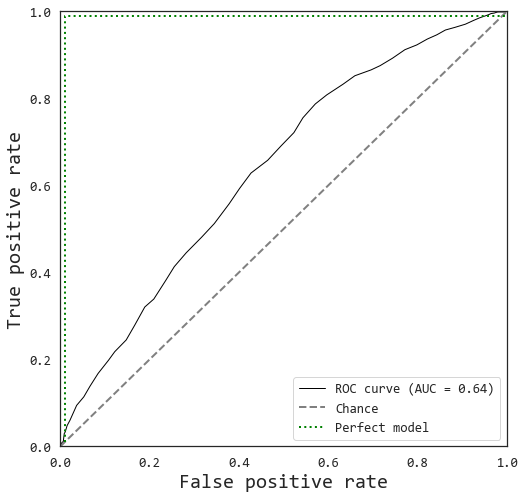

In [40]:
get_roc_plot(y_predicted_proba[:,1], y_test, figsize=(8, 8))

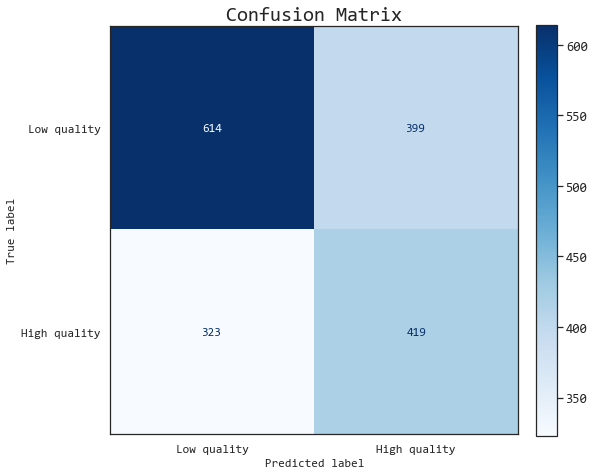

In [43]:
get_confusion_matrix_plot(y_predicted, y_test, figsize=(8, 8), cmap='Blues', values_format='d')

No handles with labels found to put in legend.


	Brier: 0.234


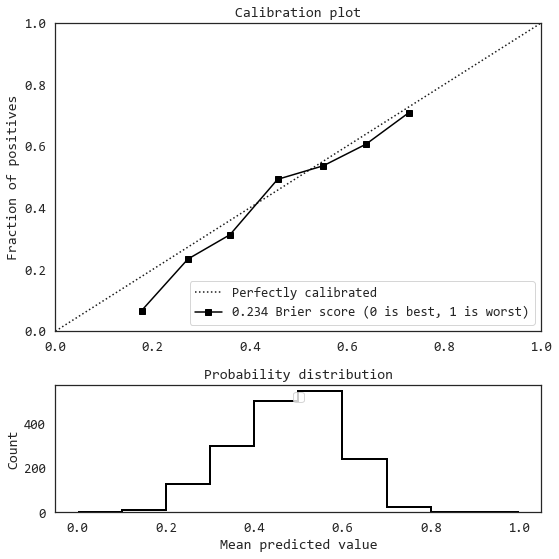

In [44]:
get_calibration_plot(y_predicted_proba[:, 1], y_test, figsize=(8, 8))

### Inference function

In [48]:
pos_prob = get_question_score_from_input("""When quoting a person's informal speech, how much liberty do you have to make changes to what they say?""")

print('{} probability of the question receiving a high score according to our model'.format(pos_prob))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/yl238/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
100%|██████████| 1/1 [00:00<00:00, 497.01it/s]

0.43 probability of the question receiving a high score according to our model
